In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3,  sfh = 3, dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.253,g102_lims=[8300, 11288], g141_lims=[11288, 16500],
              mdl_err = True, phot_errterm = 0.0, decontam = True) 

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [3]:
dres = np.load('../data/out_dict/GND_21156_assembly.npy').item()

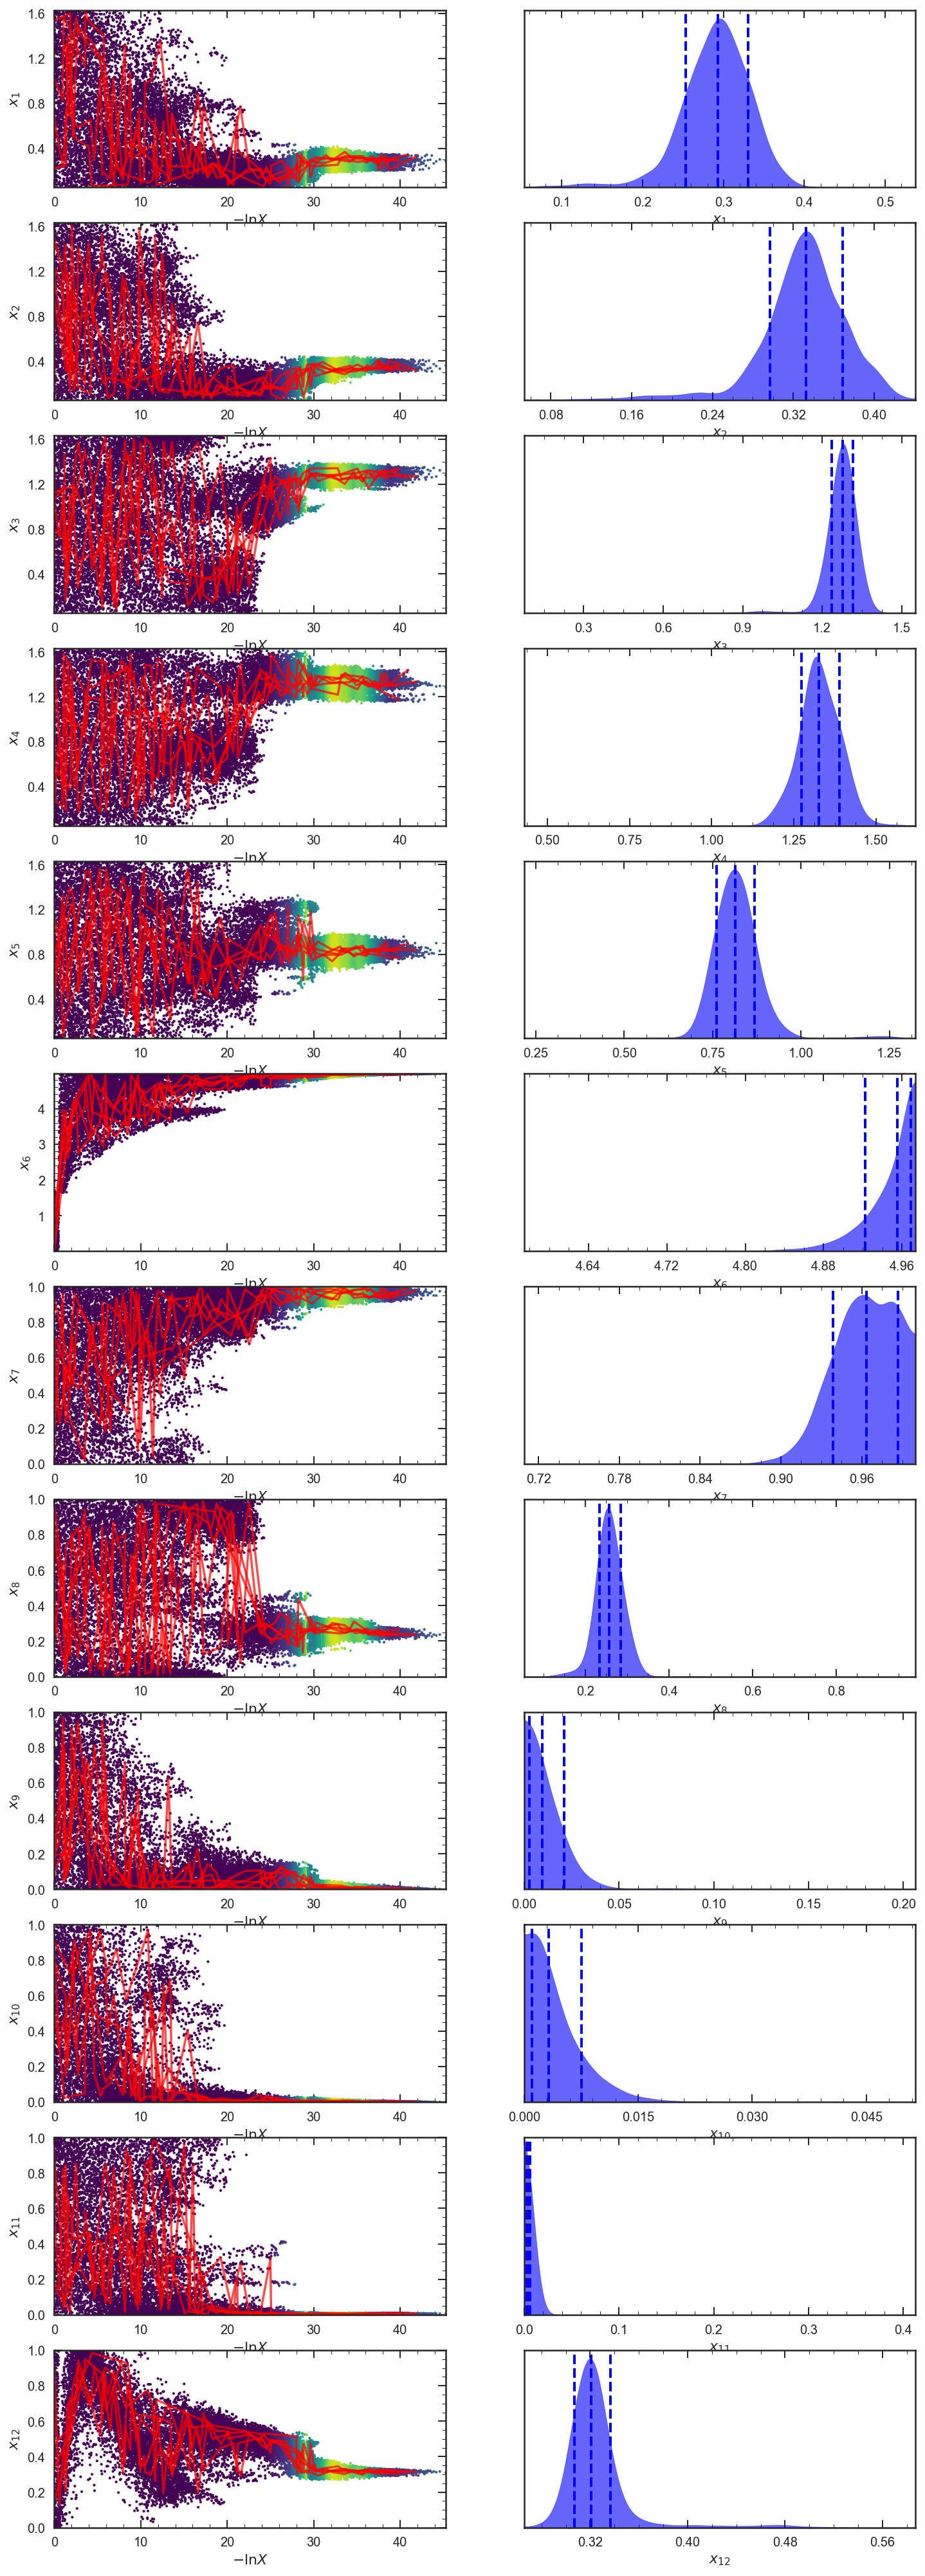

In [4]:
fig, axes = dyplot.traceplot(dres, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5))

In [4]:
def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

def Time_bins(agelim):
    lbt = np.array([0, 0.1, 0.3, 0.6, 1])
    return np.round(agelim  - lbt / 1.5 * agelim, 2)[::-1]

def get_50(LBT, md,age):
    hrtime = np.round(np.arange(0,LBT[-1],0.001),2)
    dt = 0.001
    mass = np.zeros(len(hrtime))
    mbu = 0
    u = 0
    for i in range(len(hrtime)):
        if hrtime[i] > LBT[u]:
            u+=1
        mass[i] = mbu
        mbu += md[u] * dt

    mass = mass[hrtime < age]
    hrtime = hrtime[hrtime < age]
    mass /= mass[-1]

    return interp1d(mass,hrtime)(0.5), hrtime, mass

In [5]:
Z = np.zeros(5)
Zl = np.zeros(5)
Zh = np.zeros(5)

tau = np.zeros(5)
taul = np.zeros(5)
tauh = np.zeros(5)

for i in range(5):
    t,pt = Get_posterior(dres.samples[:,i],dres.logwt,dres.logz)
    Z[i], Zl[i], Zh[i] = Highest_density_region(pt,t)
    
    t,pt = Get_posterior(dres.samples[:,i +6],dres.logwt,dres.logz)
    tau[i], taul[i], tauh[i] = Highest_density_region(pt,t)

In [6]:
T,PT = Get_posterior(dres.samples[:,5],dres.logwt,dres.logz)
age, agel, ageh = Highest_density_region(PT,T)

In [7]:
agelim = Oldest_galaxy(1.25257)
LBT = Time_bins(agelim)

In [8]:
m50, hrtime, mass = get_50(LBT, tau, age)

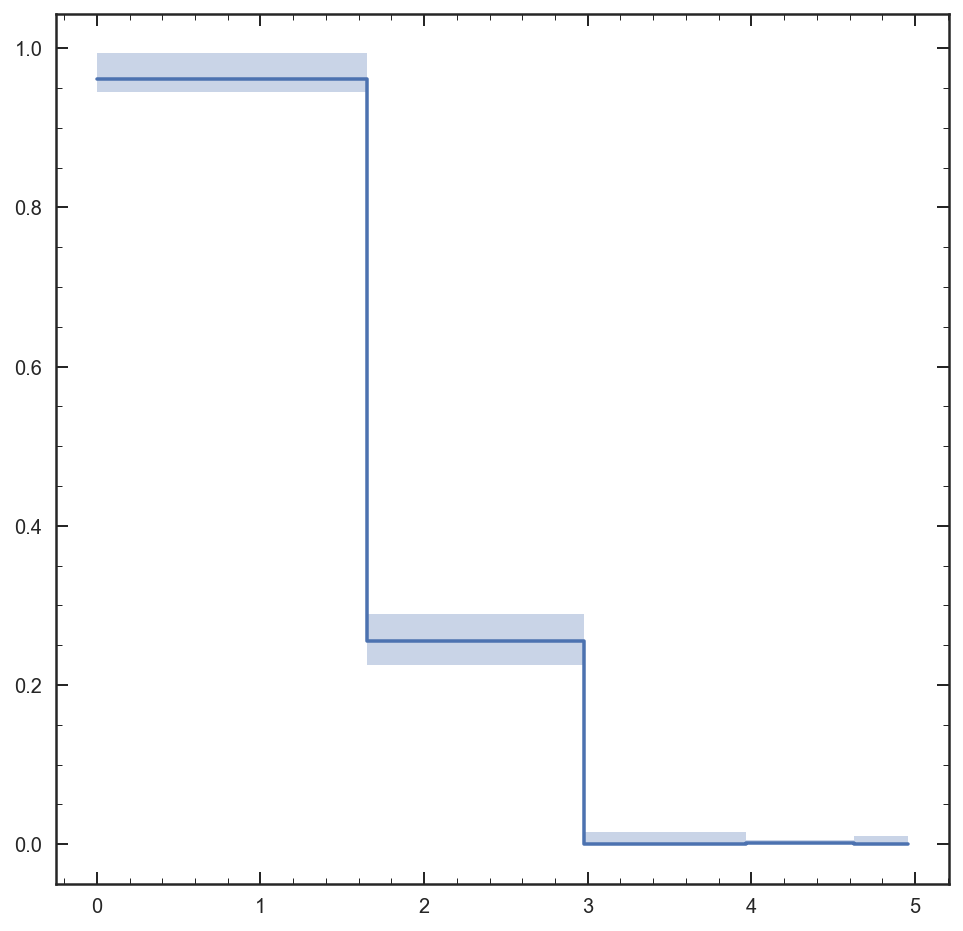

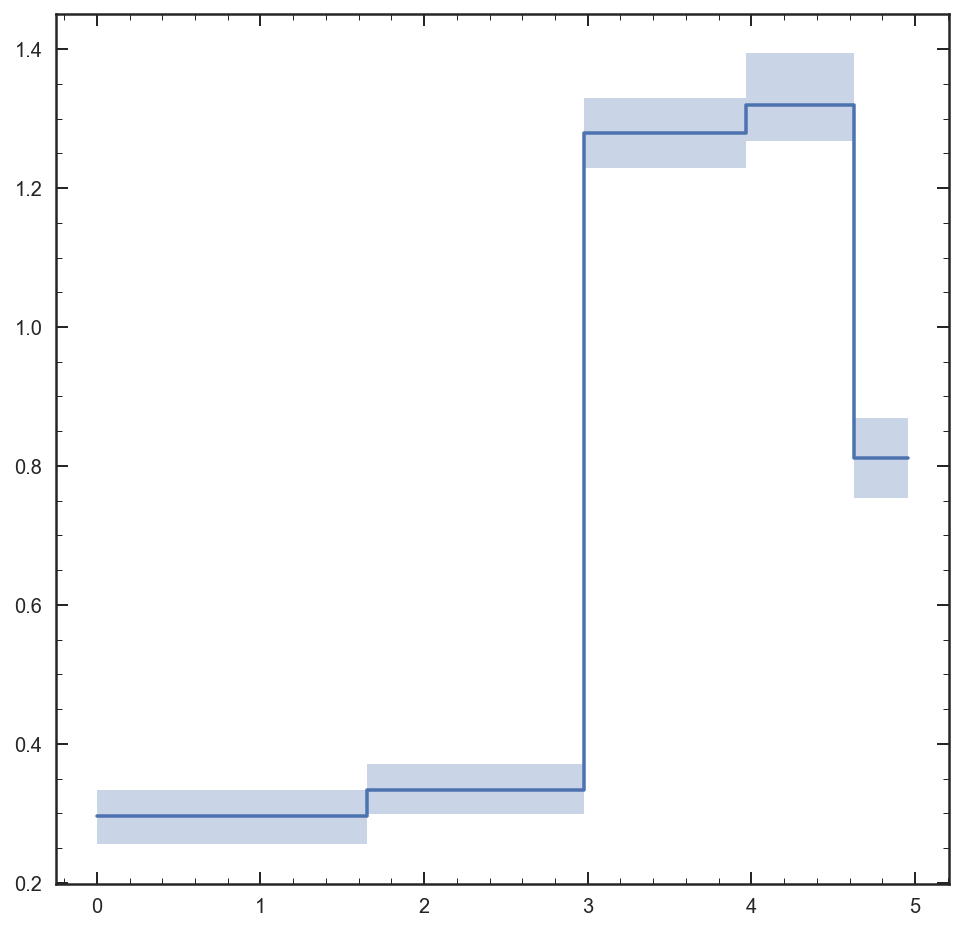

In [9]:
plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tau[0],tau))
plt.fill_between(np.append(0,LBT),np.append(tau[0],tau) - np.append(taul[0],taul),
                 np.append(tau[0],tau) + np.append(tauh[0],tauh), step = 'pre',alpha = .3)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(Z[0],Z))
plt.fill_between(np.append(0,LBT),np.append(Z[0],Z) - np.append(Zl[0],Zl),
                 np.append(Z[0],Z) + np.append(Zh[0],Zh), step = 'pre',alpha = .3)




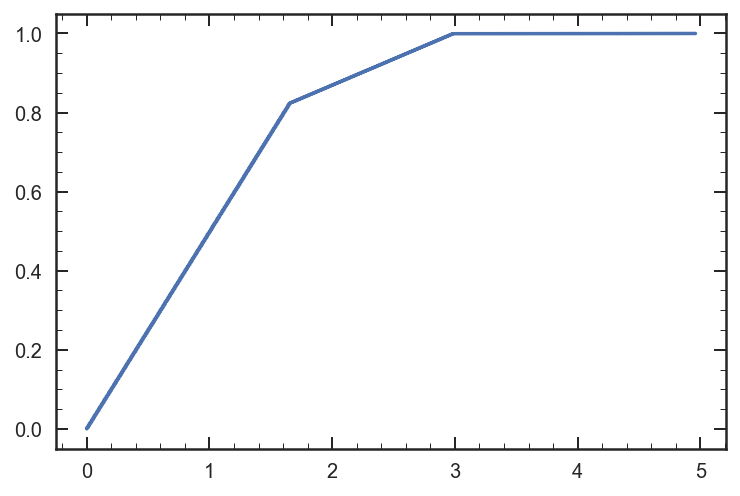

In [10]:
plt.plot(hrtime,mass)

In [11]:
Z1,Z2,Z3,Z4,Z5,t,tau1,tau2,tau3,tau4,tau5,d = dres.samples[-1]
print(dres.samples[-1])

[2.86850561e-01 3.61780436e-01 1.27760469e+00 1.28269614e+00
 7.16840346e-01 4.97269853e+00 9.68616840e-01 2.19647984e-01
 6.70487539e-04 2.27942847e-03 6.95068613e-03 3.10334098e-01]


In [12]:
sp.params['dust2'] =d
sp.params['dust1'] =d
sp.set_tabular_sfh(LBT,np.array([tau1,tau2,tau3,tau4,tau5]), Z=np.array([Z1,Z2,Z3,Z4,Z5])*0.019)
wave, flux = sp.get_spectrum(tage = t, peraa = True)

specz = 1.25257 
Gs.Sim_all_premade(wave*(1+specz),flux)

In [13]:
LBT,dres.logl

(array([1.65, 2.98, 3.97, 4.63, 4.96]),
 array([-34554.26139328, -33432.70114453, -32930.31477777, ...,
          -146.49961002,   -146.49317367,   -146.44726429]))

In [ ]:

IDB = [U for U in range(len(wave)) if wave[U] < Gs.Bwv_rf[0]]
IDR = [U for U in range(len(wave)) if wave[U] > Gs.Rwv_rf[-1]]

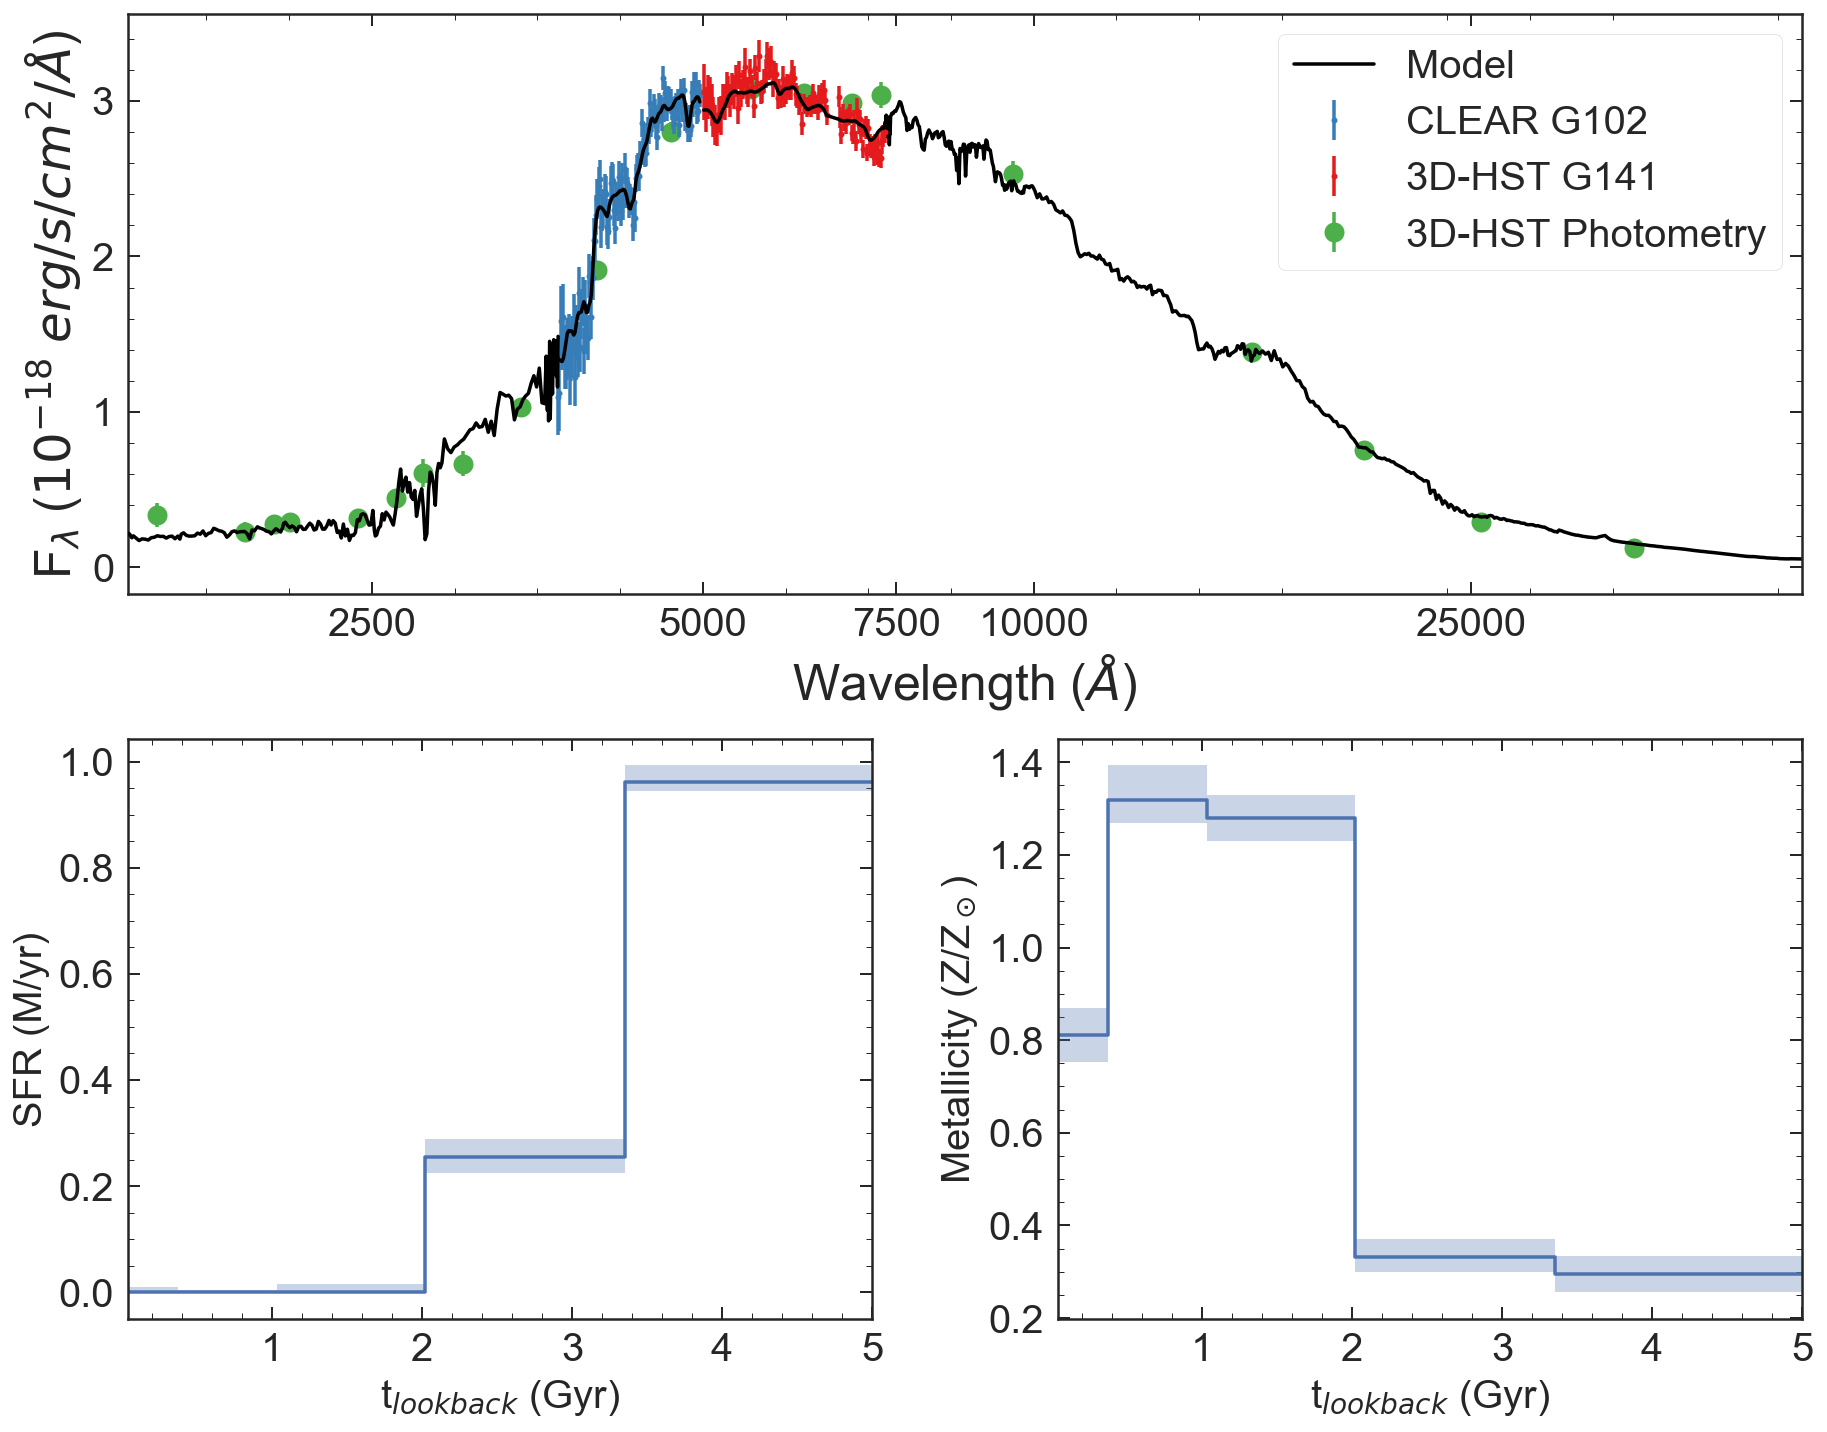

In [70]:
gs = gridspec.GridSpec(2,2, hspace=0.25,wspace=0.25)

plt.figure(figsize = [15,12])
plt.subplot(gs[0,0:])

plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18,Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18,Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='o', markersize=10, color='#4daf4a',zorder = 1, label = '3D-HST Photometry')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl*1E18, 'k', zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl*1E18, 'k', zorder=5)
# plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl*1E18, 'k*', ms = , zorder=5)

plt.plot(np.log10(wave)[IDB],flux[IDB]*Gs.PC*1E18,'k', alpha = 1, label = 'Model', zorder=5)
plt.plot(np.log10(wave)[IDR],flux[IDR]*Gs.PC*1E18,'k', alpha = 1)

plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=20, frameon=True)
plt.xlim(np.log10(1500),np.log10(50000))


plt.subplot(gs[1,0])
plt.step(np.append(0,LBT), np.append(tau[0],tau))
plt.fill_between(np.append(0,LBT),np.append(tau[0],tau) - np.append(taul[0],taul),
                 np.append(tau[0],tau) + np.append(tauh[0],tauh), step = 'pre',alpha = .3)
plt.xlabel('t$_{lookback}$ (Gyr)', fontsize=20)
plt.ylabel('SFR (M/yr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks([0,1,2,3,4,5], [5,4,3,2,1,0] )
plt.xlim(max(LBT),0)

plt.subplot(gs[1,1])
plt.step(np.append(0,LBT), np.append(Z[0],Z))
plt.fill_between(np.append(0,LBT),np.append(Z[0],Z) - np.append(Zl[0],Zl),
                 np.append(Z[0],Z) + np.append(Zh[0],Zh), step = 'pre',alpha = .3)
plt.xlabel('t$_{lookback}$ (Gyr)', fontsize=20)
plt.ylabel('Metallicity (Z/Z$_\odot$)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks([0,1,2,3,4,5], [5,4,3,2,1,0] )
plt.xlim(max(LBT),0)
plt.savefig('../plots/proposal_spec1.png' ,bbox_inches = 'tight')


In [ ]:
(sum(((Gs.Bfl - Gs.Bmfl) / Gs.Ber)**2) + sum(((Gs.Rfl - Gs.Rmfl) / Gs.Rer)**2) + sum(((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2)) * (-0.5)

In [59]:
sp.params['compute_light_ages'] = True
lwa = np.zeros(len(dres.samples))

for i in range(len(lwa)):
    Z1,Z2,Z3,Z4,Z5,t,tau1,tau2,tau3,tau4,tau5,d = dres.samples[i]
    sp.params['dust2'] =d
    sp.params['dust1'] =d
    sp.set_tabular_sfh(LBT,np.array([tau1,tau2,tau3,tau4,tau5]), Z=np.array([Z1,Z2,Z3,Z4,Z5])*0.019)
    lwa[i]= sp.get_mags(tage = t,bands = ['sdss_g'])
sp.params['compute_light_ages'] = False


In [61]:
dres.samples[:,5] = lwa

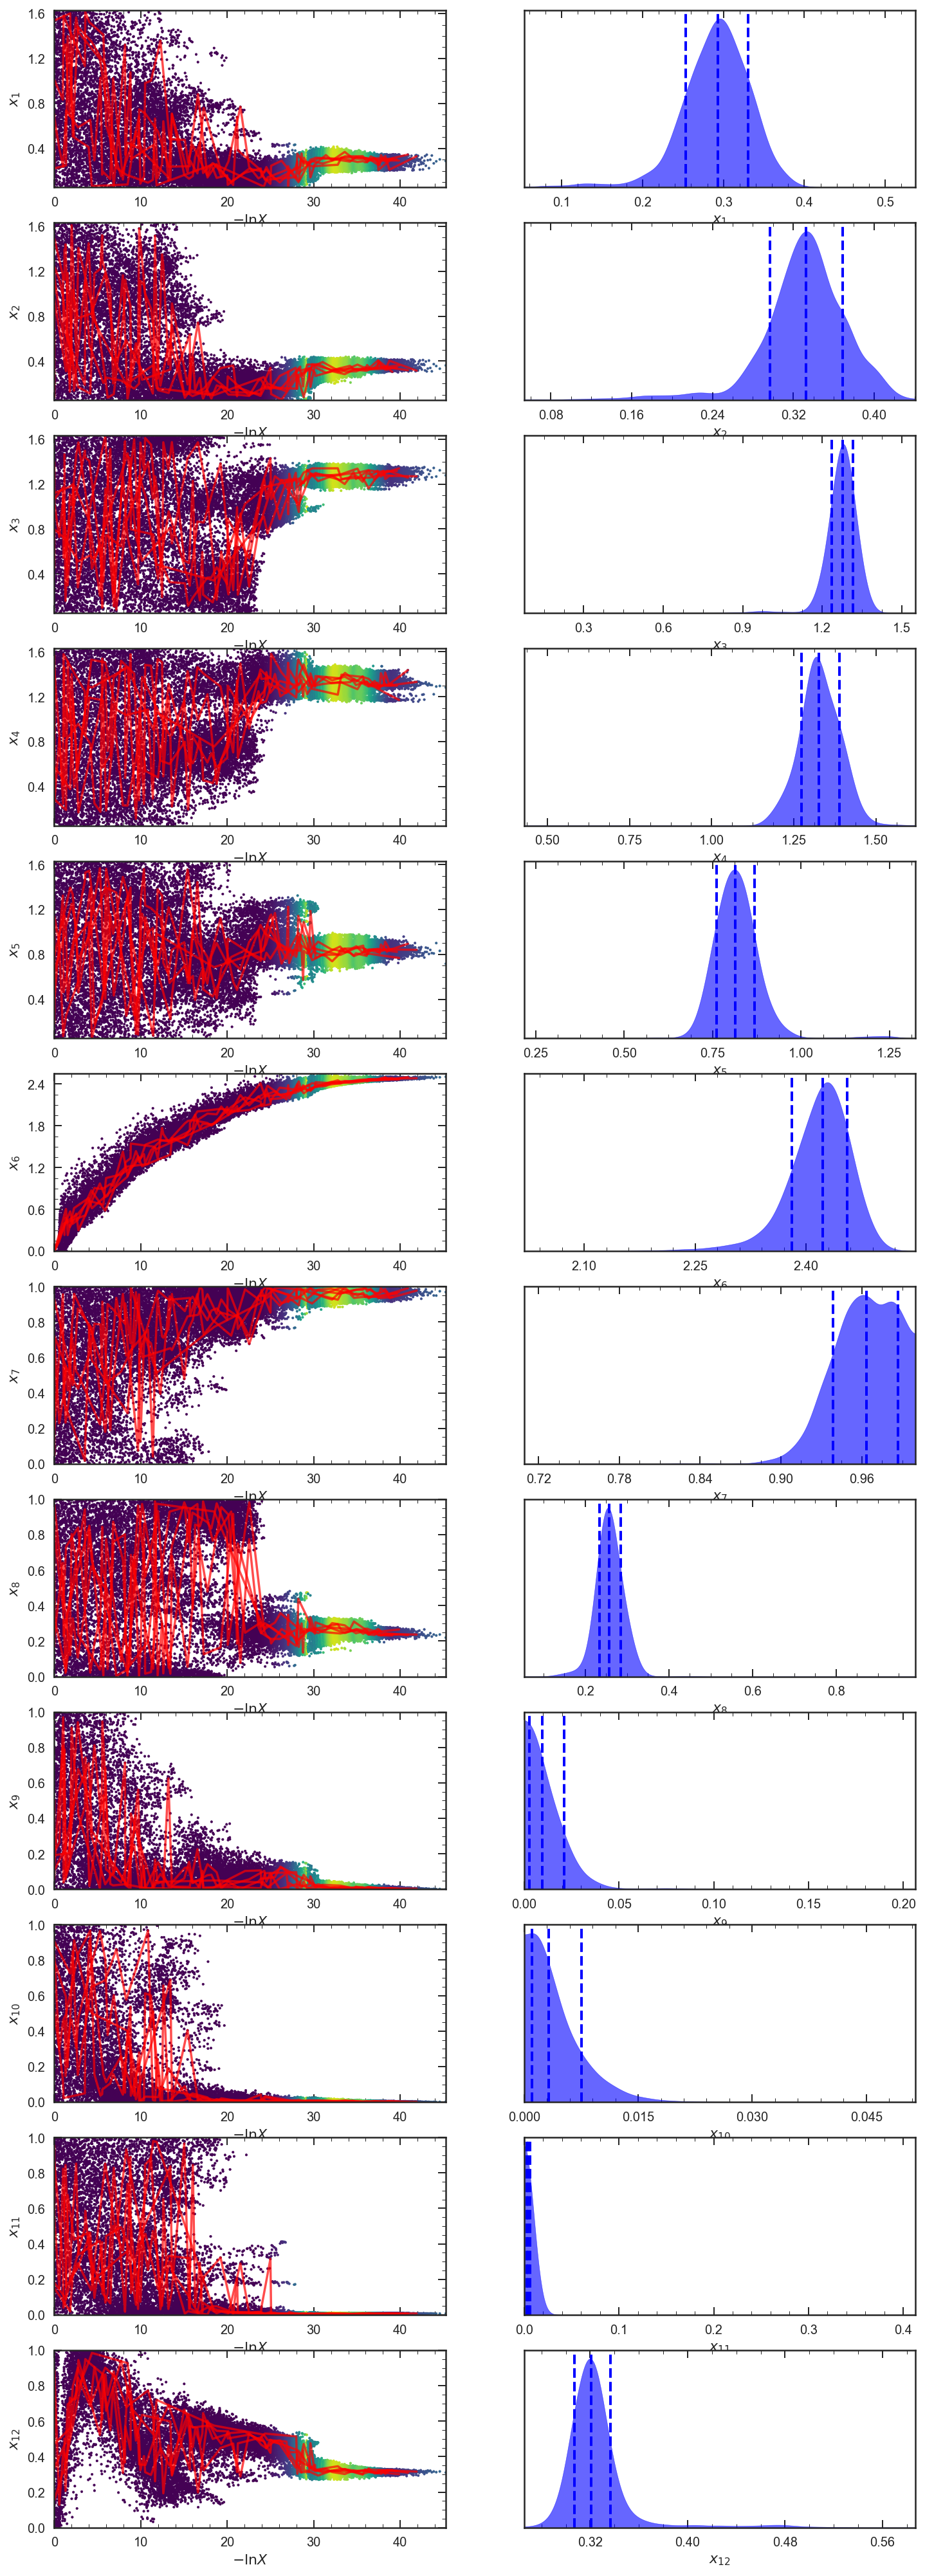

In [62]:
fig, axes = dyplot.traceplot(dres, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5))

In [63]:
m50

array(1.00791128)

In [64]:
T,PT = Get_posterior(dres.samples[:,5],dres.logwt,dres.logz)
Highest_density_region(PT,T)

(2.4289576665022192, 0.04205900358917347, 0.03481375591398672)

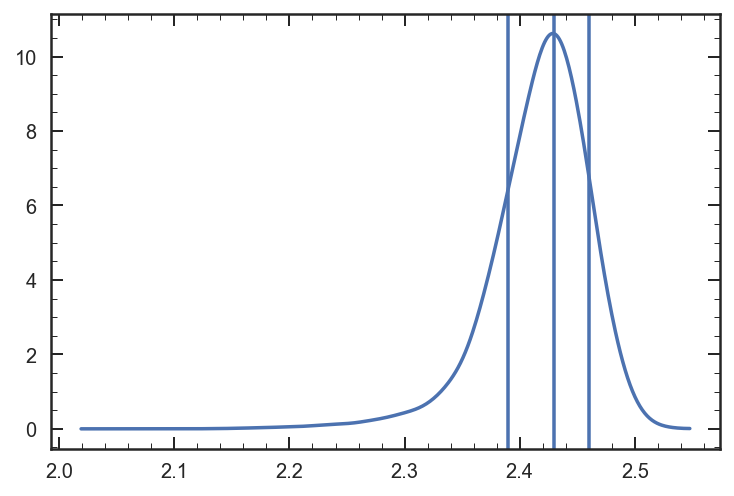

In [66]:
plt.plot(T,PT)
plt.axvline(2.43)
plt.axvline(2.43-0.04)
plt.axvline(2.43+0.03)

## find possible progenitor

In [79]:
Oldest_galaxy(2)

3.2844501468380765

In [69]:
len(lwa)

32702

In [74]:
w,f,e,n = np.load('../phot/GND_21156_phot.npy')
print(min(w), max(w))

3592.809617035445 79157.48615416403


In [75]:
w,f,e,n = np.load('../phot/GSD_41520_phot.npy')
print(min(w), max(w))

3686.439740559769 79157.48615416403
